In [ ]:
!nvidia-smi

Thu Jul 21 21:17:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from numba import cuda


cc_cores_per_SM_dict = {
    (2,0) : 32,
    (2,1) : 48,
    (3,0) : 192,
    (3,5) : 192,
    (3,7) : 192,
    (5,0) : 128,
    (5,2) : 128,
    (6,0) : 64,
    (6,1) : 128,
    (7,0) : 64,
    (7,5) : 64,
    (8,0) : 64,
    (8,6) : 128
    }
# the above dictionary should result in a value of "None" if a cc match 
# is not found.  The dictionary needs to be extended as new devices become
# available, and currently does not account for all Jetson devices
device = cuda.get_current_device()
my_sms = getattr(device, 'MULTIPROCESSOR_COUNT')
my_cc = device.compute_capability
cores_per_sm = cc_cores_per_SM_dict.get(my_cc)
total_cores = cores_per_sm*my_sms
print("GPU compute capability: " , my_cc)
print("GPU total number of SMs: " , my_sms)
print("total cores: " , total_cores)

GPU compute capability:  (7, 5)
GPU total number of SMs:  40
total cores:  2560


# **Install TensorFlow-GPU 2.0**

In [ ]:
!pip install pillow matplotlib
!pip install tensorflow-gpu==2.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
print("Tensorflow version: ", tf.version.VERSION)

Tensorflow version:  2.0.0


# **Install TensorRT Runtime**

In [ ]:
%%bash
wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

dpkg -i nvidia-machine-learning-repo-*.deb
apt-get update

sudo apt-get install libnvinfer5

(Reading database ... 155674 files and directories currently installed.)
Preparing to unpack nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb ...
Unpacking nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) over (1.0.0-1) ...
Setting up nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:5 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InReleas

--2022-07-21 21:10:45--  https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.199.39.144
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.199.39.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2926 (2.9K) [application/x-deb]
Saving to: ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb.1’

     0K ..                                                    100%  171M=0s

2022-07-21 21:10:45 (171 MB/s) - ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb.1’ saved [2926/2926]

W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1

In [ ]:
# check TensorRT version
print("TensorRT version: ")
!dpkg -l | grep nvinfer

TensorRT version: 
ii  libnvinfer5                             5.1.5-1+cuda10.1                    amd64        TensorRT runtime libraries


A successfull TensorRT installation looks like:

```
TensorRT version: 
ii  libnvinfer5   5.1.5-1+cuda10.1   amd64        TensorRT runtime libraries
```

# **Check Tensor core GPU**
The below code check whether a Tensor-core GPU is present.

In [ ]:
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
tensor_core_gpu = check_tensor_core_gpu_present()

# **Importing required libraries**

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


# **Data**
We download several random images for testing from the Internet.

In [ ]:
!mkdir ./data
!wget  -O ./data/img0.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
!wget  -O ./data/img1.JPG "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
!wget  -O ./data/img2.JPG "https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg"
!wget  -O ./data/img3.JPG "https://www.familyhandyman.com/wp-content/uploads/2018/09/How-to-Avoid-Snakes-Slithering-Up-Your-Toilet-shutterstock_780480850.jpg"

mkdir: cannot create directory ‘./data’: File exists
--2022-07-21 21:11:10--  https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630
Resolving d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)... 13.35.18.28, 13.35.18.8, 13.35.18.137, ...
Connecting to d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)|13.35.18.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24112 (24K) [image/jpeg]
Saving to: ‘./data/img0.JPG’

./data/img0.JPG     100%[===================>]  23.55K  --.-KB/s    in 0s      

2022-07-21 21:11:10 (141 MB/s) - ‘./data/img0.JPG’ saved [24112/24112]

--2022-07-21 21:11:10--  https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg
Resolving www.hakaimagazine.com (www.hakaimagazine.com)... 164.92.73.117
Connecting to www.hakaimagazine.com (www.hakaimagazine.com)|164.92.73.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45271

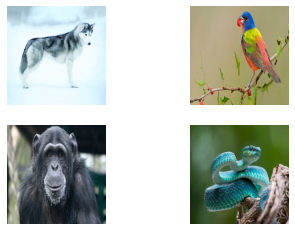

In [ ]:
from tensorflow.keras.preprocessing import image

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(4):
  img_path = './data/img%d.JPG'%i
  img = image.load_img(img_path, target_size=(224, 224))
  plt.subplot(2,2,i+1)
  plt.imshow(img);
  plt.axis('off');

# **Model**

We next download and test a ResNet-50 pre-trained model from the Keras model zoo.

In [ ]:
# !pip3 install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 12.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.0.2 which is incompatible.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorflow-estimator<2.9,>=2.8, but you have tensorflow-estimator 2.0.1 which is incompatible.


In [ ]:
import h5py

In [ ]:
h5py.__version__

'2.10.0'

In [ ]:
model = ResNet50(weights='imagenet')

40960/35363 [==================================] - 0s 0us/step
./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5566199), ('n02109961', 'Eskimo_dog', 0.41737354), ('n02110063', 'malamute', 0.020951513)]
./data/img1.JPG - Predicted: [('n01820546', 'lorikeet', 0.30138975), ('n01537544', 'indigo_bunting', 0.16979532), ('n01828970', 'bee_eater', 0.16134124)]
./data/img2.JPG - Predicted: [('n02481823', 'chimpanzee', 0.5149853), ('n02480495', 'orangutan', 0.1589676), ('n02480855', 'gorilla', 0.15318194)]
./data/img3.JPG - Predicted: [('n01729977', 'green_snake', 0.41596198), ('n03627232', 'knot', 0.100652136), ('n01749939', 'green_mamba', 0.06704981)]


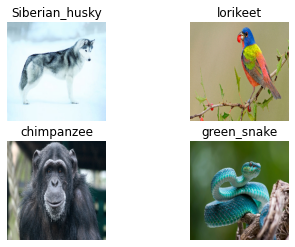

In [ ]:
for i in range(4):
  img_path = './data/img%d.JPG'%i
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  # decode the results into a list of tuples (class, description, probability)
  # (one such list for each sample in the batch)
  print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))

  plt.subplot(2,2,i+1)
  plt.imshow(img);
  plt.axis('off');
  plt.title(decode_predictions(preds, top=3)[0][0][1])
    

TF-TRT takes input as aTensorFlow saved model, therefore, we re-export the Keras model as a TF saved model.

In [ ]:
# Save the entire model as a SavedModel.
model.save('resnet50_saved_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: resnet50_saved_model/assets


In [ ]:
!saved_model_cli show --all --dir resnet50_saved_model


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['probs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1000)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


# **Inference with native TF2.0 saved model**

In [ ]:
model = tf.keras.models.load_model('resnet50_saved_model')

./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.556619), ('n02109961', 'Eskimo_dog', 0.41737446), ('n02110063', 'malamute', 0.02095156)]


Text(0.5, 1.0, 'Siberian_husky')

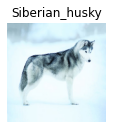

In [ ]:
img_path = './data/img0.JPG'  # Siberian_husky
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))
plt.subplot(2,2,1)
plt.imshow(img);
plt.axis('off');
plt.title(decode_predictions(preds, top=3)[0][0][1])

In [ ]:
batch_size = 8
batched_input = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)

for i in range(batch_size):
  img_path = './data/img%d.JPG' % (i % 4)
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (8, 224, 224, 3)


In [ ]:
# Benchmarking throughput
N_warmup_run = 50
N_run = 1000
elapsed_time = []

for i in range(N_warmup_run):
  preds = model.predict(batched_input)

for i in range(N_run):
  start_time = time.time()
  preds = model.predict(batched_input)
  end_time = time.time()
  elapsed_time = np.append(elapsed_time, end_time - start_time)
  if i % 50 == 0:
    print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

Step 0: 39.1ms
Step 50: 39.7ms
Step 100: 40.1ms
Step 150: 39.6ms
Step 200: 39.8ms
Step 250: 40.1ms
Step 300: 39.9ms
Step 350: 46.1ms
Step 400: 41.2ms
Step 450: 40.0ms
Step 500: 39.8ms
Step 550: 39.9ms
Step 600: 39.9ms
Step 650: 40.0ms
Step 700: 39.6ms
Step 750: 40.0ms
Step 800: 40.0ms
Step 850: 40.6ms
Step 900: 40.1ms
Step 950: 40.0ms
Throughput: 198 images/s


# **TF-TRT FP32 model**

We first convert the TF native FP32 model to a TF-TRT FP32 model.

In [ ]:
print('Converting to TF-TRT FP32...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP32,
                                                               max_workspace_size_bytes=8000000000)

converter = trt.TrtGraphConverterV2(input_saved_model_dir='resnet50_saved_model',
                                    conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP32')
print('Done Converting to TF-TRT FP32')

Converting to TF-TRT FP32...
INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP32/assets
Done Converting to TF-TRT FP32


In [ ]:
!saved_model_cli show --all --dir resnet50_saved_model_TFTRT_FP32


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 224, 224, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['probs'] tensor_info:
        dtype: DT_FLOAT
        shape: unknown_rank
        name: PartitionedCall:0
  Method name is: tensorflow/serving/predict


Next, we load and test the TF-TRT FP32 model.

In [ ]:
def predict_tftrt(input_saved_model):
    """Runs prediction on a single image and shows the result.
    input_saved_model (string): Name of the input model stored in the current dir
    """
    img_path = './data/img0.JPG'  # Siberian_husky
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = tf.constant(x)
    
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    signature_keys = list(saved_model_loaded.signatures.keys())
    print(signature_keys)

    infer = saved_model_loaded.signatures['serving_default']
    print(infer.structured_outputs)

    labeling = infer(x)
    preds = labeling['probs'].numpy()
    print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))
    plt.subplot(2,2,1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(decode_predictions(preds, top=3)[0][0][1])

['serving_default']
{'probs': TensorSpec(shape=<unknown>, dtype=tf.float32, name='probs')}
./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5566207), ('n02109961', 'Eskimo_dog', 0.41737258), ('n02110063', 'malamute', 0.020951604)]


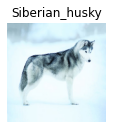

In [ ]:
predict_tftrt('resnet50_saved_model_TFTRT_FP32')

In [ ]:
def benchmark_tftrt(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 50
    N_run = 1000
    elapsed_time = []

    for i in range(N_warmup_run):
      labeling = infer(batched_input)

    for i in range(N_run):
      start_time = time.time()
      labeling = infer(batched_input)
      #prob = labeling['probs'].numpy()
      end_time = time.time()
      elapsed_time = np.append(elapsed_time, end_time - start_time)
      if i % 50 == 0:
        print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

In [ ]:
benchmark_tftrt('resnet50_saved_model_TFTRT_FP32')

Step 0: 17.5ms
Step 50: 17.0ms
Step 100: 17.1ms
Step 150: 17.1ms
Step 200: 17.1ms
Step 250: 17.1ms
Step 300: 17.1ms
Step 350: 17.1ms
Step 400: 17.1ms
Step 450: 17.1ms
Step 500: 17.1ms
Step 550: 17.2ms
Step 600: 17.1ms
Step 650: 17.1ms
Step 700: 17.2ms
Step 750: 17.4ms
Step 800: 17.3ms
Step 850: 17.3ms
Step 900: 17.3ms
Step 950: 17.2ms
Throughput: 466 images/s


# **TF-TRT FP16 model**
We next convert the native TF FP32 saved model to TF-TRT FP16 model.

In [ ]:
print('Converting to TF-TRT FP16...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.FP16,
    max_workspace_size_bytes=8000000000)
converter = trt.TrtGraphConverterV2(
   input_saved_model_dir='resnet50_saved_model', conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_FP16')
print('Done Converting to TF-TRT FP16')

Converting to TF-TRT FP16...
INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_FP16/assets
Done Converting to TF-TRT FP16


['serving_default']
{'probs': TensorSpec(shape=<unknown>, dtype=tf.float32, name='probs')}
./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5543133), ('n02109961', 'Eskimo_dog', 0.41906938), ('n02110063', 'malamute', 0.021390611)]


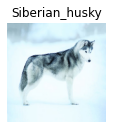

In [ ]:
predict_tftrt('resnet50_saved_model_TFTRT_FP16')

In [ ]:
benchmark_tftrt('resnet50_saved_model_TFTRT_FP16')

Step 0:  5.6ms
Step 50:  5.6ms
Step 100:  5.6ms
Step 150:  5.7ms
Step 200:  5.6ms
Step 250:  5.7ms
Step 300:  5.6ms
Step 350:  5.6ms
Step 400:  5.6ms
Step 450:  5.6ms
Step 500:  5.6ms
Step 550:  5.6ms
Step 600:  5.7ms
Step 650:  5.6ms
Step 700:  5.7ms
Step 750:  5.5ms
Step 800:  5.6ms
Step 850:  5.6ms
Step 900:  5.6ms
Step 950:  5.7ms
Throughput: 1424 images/s


# **TF-TRT INT8 model**

Creating TF-TRT INT8 model requires a small calibration dataset. This data set ideally should represent the test data in production well, and will be used to create a value histogram for each layer in the neural network for effective 8-bit quantization.  

Herein, for demonstration purposes, we take only the 4 images that we downloaded for calibration. In production, this set should be more representative of the production data.

Due to Colab memory limit which sometime causes TensorRT to crash, to proceed, first, restart the runtime by pressing CTRL+M or select *Runtime -> Restart runtime...* or simply execute the next cell.

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:

from __future__ import absolute_import, division, print_function, unicode_literals
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
batch_size = 8
batched_input = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)

for i in range(batch_size):
  img_path = './data/img%d.JPG' % (i % 4)
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (8, 224, 224, 3)


In [ ]:
print('Converting to TF-TRT INT8...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.INT8, 
    max_workspace_size_bytes=8000000000, 
    use_calibration=True)
converter = trt.TrtGraphConverterV2(
    input_saved_model_dir='resnet50_saved_model', 
    conversion_params=conversion_params)

def calibration_input_fn():
    yield (batched_input, )
converter.convert(calibration_input_fn=calibration_input_fn)

converter.save(output_saved_model_dir='resnet50_saved_model_TFTRT_INT8')
print('Done Converting to TF-TRT INT8')

Converting to TF-TRT INT8...
INFO:tensorflow:Linked TensorRT version: (5, 1, 5)
INFO:tensorflow:Loaded TensorRT version: (5, 1, 5)
INFO:tensorflow:Running against TensorRT version 5.1.5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: resnet50_saved_model_TFTRT_INT8/assets
Done Converting to TF-TRT INT8


In [ ]:
def predict_tftrt(input_saved_model):
    """Runs prediction on a single image and shows the result.
    input_saved_model (string): Name of the input model stored in the current dir
    """
    img_path = './data/img0.JPG'  # Siberian_husky
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = tf.constant(x)
    
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    signature_keys = list(saved_model_loaded.signatures.keys())
    print(signature_keys)

    infer = saved_model_loaded.signatures['serving_default']
    print(infer.structured_outputs)

    labeling = infer(x)
    preds = labeling['probs'].numpy()
    print('{} - Predicted: {}'.format(img_path, decode_predictions(preds, top=3)[0]))
    plt.subplot(2,2,1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(decode_predictions(preds, top=3)[0][0][1])

['serving_default']
{'probs': TensorSpec(shape=<unknown>, dtype=tf.float32, name='probs')}
./data/img0.JPG - Predicted: [('n02110185', 'Siberian_husky', 0.5640652), ('n02109961', 'Eskimo_dog', 0.41267893), ('n02110063', 'malamute', 0.019913938)]


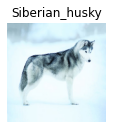

In [ ]:
predict_tftrt('resnet50_saved_model_TFTRT_INT8')

In [ ]:
def benchmark_tftrt(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 50
    N_run = 1000
    elapsed_time = []

    for i in range(N_warmup_run):
      labeling = infer(batched_input)

    for i in range(N_run):
      start_time = time.time()
      labeling = infer(batched_input)
      #prob = labeling['probs'].numpy()
      end_time = time.time()
      elapsed_time = np.append(elapsed_time, end_time - start_time)
      if i % 50 == 0:
        print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

In [ ]:
benchmark_tftrt('resnet50_saved_model_TFTRT_INT8')

Step 0:  3.4ms
Step 50:  3.4ms
Step 100:  3.3ms
Step 150:  3.3ms
Step 200:  3.3ms
Step 250:  3.3ms
Step 300:  3.2ms
Step 350:  3.3ms
Step 400:  3.4ms
Step 450:  3.3ms
Step 500:  3.3ms
Step 550:  3.3ms
Step 600:  3.4ms
Step 650:  3.3ms
Step 700:  3.4ms
Step 750:  3.3ms
Step 800:  3.4ms
Step 850:  3.3ms
Step 900:  3.3ms
Step 950:  3.3ms
Throughput: 2411 images/s


# **Conclusion**
Image dimension : 224*224*3 \n
Comparing Throughput Profile for 
##    FLOAT32          TRT FLOAT32,          TRT FLOAT16,           TRT INT8
## 198 images/sec,   466 images/sec,      1424 images/sec,     2411 images/sec
##      x,                 2x,                    7x,                 12x